In [1]:
import numpy as np
import pandas as pd
import shap # Explainable AI
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import os
import time

try:
    from keras_flops import get_flops
except KeyError:
    print("FLOPs already registered; skipping re-import.")

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


FLOPs already registered; skipping re-import.


# Explainable Generative AI Enabled LSTM Energy Load Forecasting with Federated Learning, LLM and Crytography 

## For Each Node:

In [2]:
# Load the data from the file 'household_power_consumption.txt' using pandas
# and specify the delimiter as ';'

#file_path = 'C:/path/to/your/file.csv'
file_path = 'E:/Study/Rsearch/## UKM Masters/#Processed London Dataset/DailyDataset/SmartMeterID_of_Block_0/Block_0_MAC001074.csv'

#data = pd.read_csv('MAC000450.csv')
data = pd.read_csv(file_path)

# Print the number of rows and columns in the data
print('Number of rows and columns:', data.shape)

# Display the first 5 rows of the data
data.head(5)

Number of rows and columns: (227, 9)


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC001074,5/8/2012,0.2280,0.373222,1.662,27,0.369933,10.077,0.074
1,MAC001074,5/9/2012,0.2225,0.568063,3.515,48,0.777467,27.267,0.086
2,MAC001074,5/10/2012,0.2345,0.400396,1.781,48,0.410944,19.219,0.077
3,MAC001074,5/11/2012,0.2910,0.408062,1.789,48,0.377069,19.587,0.077
4,MAC001074,5/12/2012,0.3150,0.629687,2.978,48,0.606279,30.225,0.111


In [3]:
data = data[['day', 'energy_sum']]
data.head(5)

,day,energy_sum
0,5/8/2012,10.077
1,5/9/2012,27.267
2,5/10/2012,19.219
3,5/11/2012,19.587
4,5/12/2012,30.225


In [4]:
data.tail(5)

,day,energy_sum
222,12/16/2012,26.700
223,12/17/2012,28.963
224,12/18/2012,22.202
225,12/19/2012,31.791
226,12/20/2012,25.055


In [5]:
data['day'] = pd.to_datetime(data['day'])
data.set_index('day', inplace=True)
data.head(5)

,energy_sum
day,
2012-05-08,10.077
2012-05-09,27.267
2012-05-10,19.219
2012-05-11,19.587
2012-05-12,30.225


In [6]:
# Resample to daily data if necessary (not needed here since data is already daily)
# data = data.resample('D').sum()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['energy_sum']])

In [7]:
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict energy_sum
    return np.array(X), np.array(y)

In [8]:
# Set time step
time_step = 30  # Use the past 7 days to predict the next day
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define the MAPE Callback
class AverageMapeCallback(Callback):
    def __init__(self, validation_data):
        super(AverageMapeCallback, self).__init__()
        self.validation_data = validation_data
        self.mape_values = []

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on the validation set
        y_pred = self.model.predict(self.validation_data[0])
        # Calculate MAPE
        mape = np.mean(np.abs((self.validation_data[1] - y_pred) / self.validation_data[1])) * 100
        self.mape_values.append(mape)
        print(f"Epoch {epoch + 1}: MAPE = {mape:.4f}")

    def on_train_end(self, logs=None):
        # Calculate and print average MAPE across all epochs
        average_mape = np.mean(self.mape_values)
        print(f"Average Mean Absolute Percentage Error (MAPE): {average_mape:.4f}")

# Initialize the Average MAPE callback with validation data
mape_callback = AverageMapeCallback(validation_data=(X_test, y_test))

### LSTM neural network

In [10]:
#model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
        callbacks=[EarlyStopping(monitor='val_loss', patience=25),mape_callback], verbose=2, shuffle=False)



Epoch 1/50


2/2 [==============================] - 14s 59ms/step
Epoch 1: MAPE = 59.5898
5/5 - 123s - loss: 0.3362 - mae: 0.5573 - accuracy: 0.0000e+00 - val_loss: 0.1431 - val_mae: 0.3650 - val_accuracy: 0.0000e+00 - 123s/epoch - 25s/step
Epoch 2/50
2/2 [==============================] - 0s 48ms/step
Epoch 2: MAPE = 24.9153
5/5 - 2s - loss: 0.0798 - mae: 0.2340 - accuracy: 0.0000e+00 - val_loss: 0.0179 - val_mae: 0.1136 - val_accuracy: 0.0000e+00 - 2s/epoch - 437ms/step
Epoch 3/50
2/2 [==============================] - 0s 49ms/step
Epoch 3: MAPE = 25.3556
5/5 - 2s - loss: 0.0508 - mae: 0.1838 - accuracy: 0.0064 - val_loss: 0.0187 - val_mae: 0.1171 - val_accuracy: 0.0000e+00 - 2s/epoch - 455ms/step
Epoch 4/50
2/2 [==============================] - 0s 44ms/step
Epoch 4: MAPE = 17.1883
5/5 - 2s - loss: 0.0200 - mae: 0.1106 - accuracy: 0.0064 - val_loss: 0.0132 - val_mae: 0.0890 - val_accuracy: 0.0000e+00 - 2s/epoch - 453ms/step
Epoch 5/50
2/2 [==============================] - 0s 67ms

Epoch 32/50
2/2 [==============================] - 1s 62ms/step
Epoch 32: MAPE = 17.2900
5/5 - 3s - loss: 0.0161 - mae: 0.0985 - accuracy: 0.0064 - val_loss: 0.0079 - val_mae: 0.0680 - val_accuracy: 0.0000e+00 - 3s/epoch - 569ms/step
Epoch 33/50
2/2 [==============================] - 0s 97ms/step
Epoch 33: MAPE = 16.9247
5/5 - 4s - loss: 0.0169 - mae: 0.0960 - accuracy: 0.0064 - val_loss: 0.0077 - val_mae: 0.0675 - val_accuracy: 0.0000e+00 - 4s/epoch - 721ms/step
Epoch 34/50
2/2 [==============================] - 1s 45ms/step
Epoch 34: MAPE = 16.4971
5/5 - 3s - loss: 0.0163 - mae: 0.0981 - accuracy: 0.0064 - val_loss: 0.0078 - val_mae: 0.0689 - val_accuracy: 0.0000e+00 - 3s/epoch - 633ms/step
Epoch 35/50
2/2 [==============================] - 0s 49ms/step
Epoch 35: MAPE = 16.8233
5/5 - 2s - loss: 0.0180 - mae: 0.1031 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_mae: 0.0676 - val_accuracy: 0.0000e+00 - 2s/epoch - 479ms/step
Epoch 36/50
2/2 [==============================] - 0s 77ms/s

In [11]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Inverse transform to original scale

2/2 [==============================] - 0s 40ms/step


In [12]:
# Create a DataFrame for actual and predicted values
predicted_df = pd.DataFrame(data={'Actual': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), 
                                   'Predicted': predicted.flatten()},
                            index=data.index[-len(y_test):])

### Actual vs Predicted 

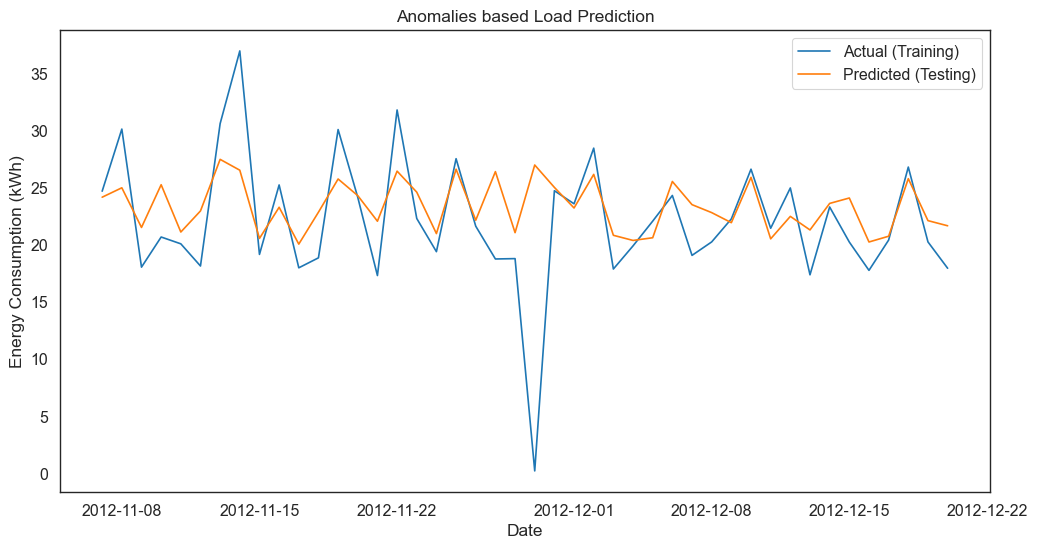

In [124]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df['Actual'], label='Actual (Training)')
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted (Testing)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('Anomalies based Load Prediction')
plt.show()

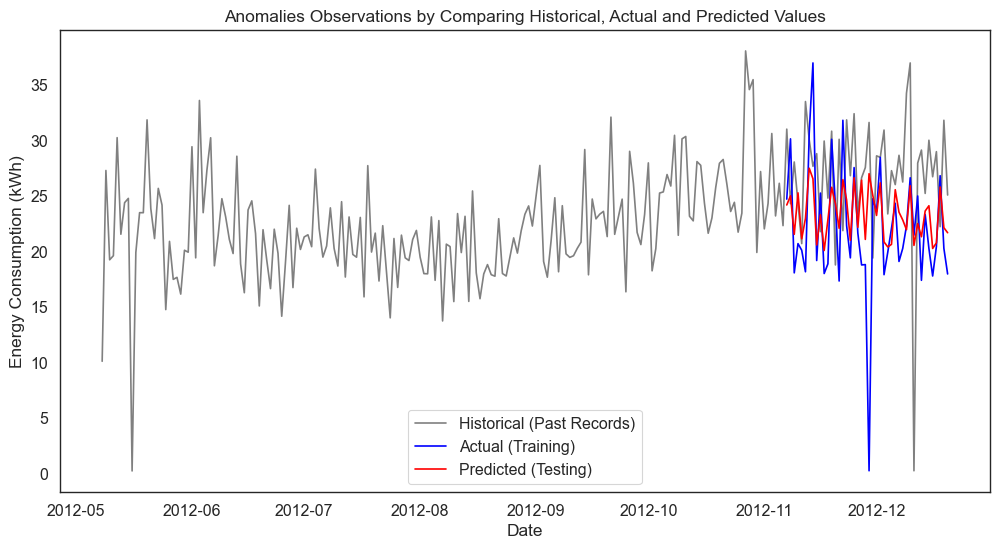

In [125]:
# Combine historical data with predictions
historical_data = data[['energy_sum']].copy()  # Get the historical data
historical_data = historical_data.rename(columns={'energy_sum': 'Actual'})  # Rename column for clarity

# Concatenate historical data with predicted values
#combined_df = pd.concat([historical_data, predicted_df], axis=1)
combined_df = pd.concat([historical_data], axis=1)

# Fill any NaN values that may occur in the combined DataFrame
combined_df.fillna(method='ffill', inplace=True)  # Forward fill to propagate last valid observation

# Plot the historical and predicted values
plt.figure(figsize=(12, 6))
#plt.plot(combined_df.index, combined_df['Actual'], label='Actual (Historical)', color='blue')
plt.plot(combined_df.index, combined_df['Actual'], label='Historical (Past Records)', color='gray')
plt.plot(predicted_df.index, predicted_df['Actual'], label='Actual (Training)', color='blue')
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted (Testing)', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('Anomalies Observations by Comparing Historical, Actual and Predicted Values')
plt.show()

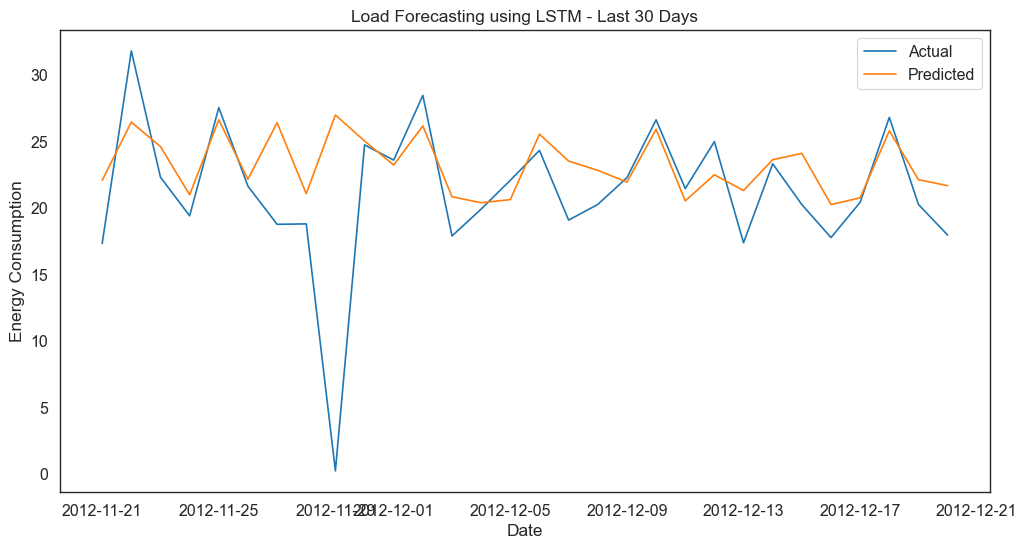

In [126]:
# Select the last 30 days
last_30_days = predicted_df.tail(30)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(last_30_days.index, last_30_days['Actual'], label='Actual')
plt.plot(last_30_days.index, last_30_days['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.title('Load Forecasting using LSTM - Last 30 Days')
plt.show()

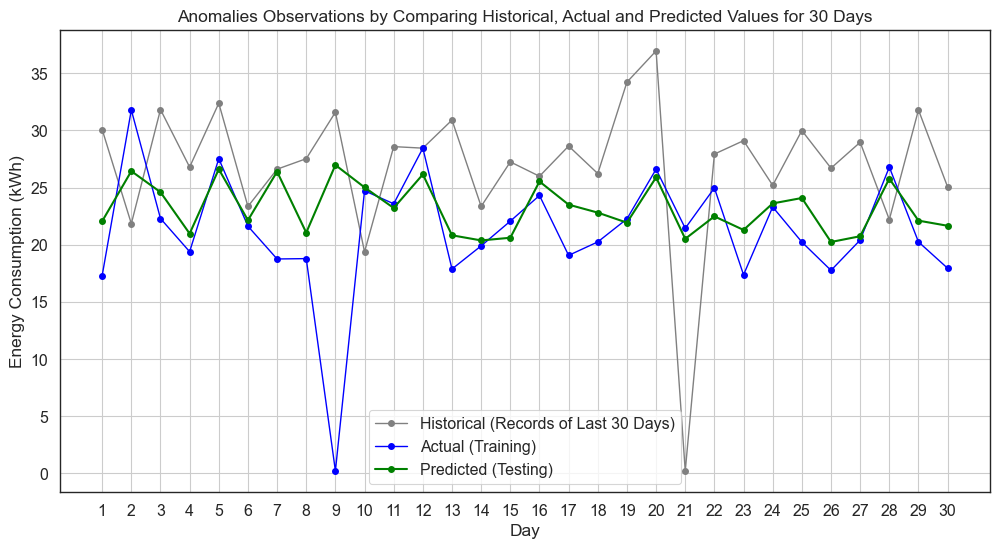

In [127]:
historical_data = data[['energy_sum']].copy()  # Get the historical data
historical_data = historical_data.rename(columns={'energy_sum': 'Actual'})  # Rename column for clarity
historical_df = pd.concat([historical_data], axis=1)
historical_df.fillna(method='ffill', inplace=True)  # Forward fill to propagate last valid observation
historical_df = historical_df.tail(30)


# Select the last 30 days
last_30_days = predicted_df.tail(30)

# Generate a sequence of numbers for x-axis labels starting from 1
x_labels = range(1, len(last_30_days) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(x_labels, historical_df['Actual'], linewidth=1, marker='.', label='Historical (Records of Last 30 Days)', color='gray', markersize=8)
plt.plot(x_labels, last_30_days['Actual'], linewidth=1, marker='.', label='Actual (Training)', color='blue', markersize=8)
plt.plot(x_labels, last_30_days['Predicted'], linewidth=1.5, marker='.', label='Predicted (Testing)', color='green', markersize=8)

# Set x-ticks to match the day labels
plt.xticks(x_labels)

# Add grid
plt.grid(True)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('Anomalies Observations by Comparing Historical, Actual and Predicted Values for 30 Days')

# Show the plot
plt.show()


#### Explinable AI (XAI) for the prediction

In [86]:
# Our X_test is currently shaped (samples, time_steps, 1)
# We need to flatten it into (samples, time_steps)
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [87]:
# Defining a simple prediction function for SHAP

# Because our LSTM expects 3D input (samples, time_steps, features), but SHAP will send 2D input, 
# we wrap model.predict inside a small function:

def model_predict_for_XAI(x):
    x_reshaped_for_XAI = x.reshape((x.shape[0], time_step, 1))  # reshape back for LSTM
    return model.predict(x_reshaped_for_XAI)

In [88]:
# Create the explainer
explainer = shap.Explainer(model_predict_for_XAI, X_test_flat)

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [89]:
# Calculate SHAP values
shap_values = explainer(X_test_flat)

329/329 [==============================] - 7s 20ms/step


ExactExplainer explainer:   1%|▊                                                                | 1/83 [00:00<?, ?it/s]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:   4%|██                                                       | 3/83 [00:51<05:55,  4.44s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:   5%|██▋                                                      | 4/83 [01:03<10:24,  7.91s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:   6%|███▍                                                     | 5/83 [01:14<11:33,  8.90s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:   7%|████                                                     | 6/83 [01:26<12:45,  9.95s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:   8%|████▊                                                    | 7/83 [01:35<12:17,  9.71s/it]

21/21 [==============================] - 1s 26ms/step


ExactExplainer explainer:  10%|█████▍                                                   | 8/83 [01:44<12:00,  9.61s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  11%|██████▏                                                  | 9/83 [01:54<11:40,  9.47s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  12%|██████▋                                                 | 10/83 [02:03<11:23,  9.36s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  13%|███████▍                                                | 11/83 [02:12<11:06,  9.25s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  14%|████████                                                | 12/83 [02:21<10:51,  9.17s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  16%|████████▊                                               | 13/83 [02:30<10:38,  9.13s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  17%|█████████▍                                              | 14/83 [02:39<10:27,  9.09s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  18%|██████████                                              | 15/83 [02:50<11:14,  9.92s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  19%|██████████▊                                             | 16/83 [03:00<10:47,  9.66s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  20%|███████████▍                                            | 17/83 [03:08<10:23,  9.44s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  22%|████████████▏                                           | 18/83 [03:17<10:03,  9.29s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  23%|████████████▊                                           | 19/83 [03:26<09:49,  9.21s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  24%|█████████████▍                                          | 20/83 [03:35<09:33,  9.10s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  25%|██████████████▏                                         | 21/83 [03:47<10:13,  9.90s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  27%|██████████████▊                                         | 22/83 [03:59<10:37, 10.44s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  28%|███████████████▌                                        | 23/83 [04:08<10:00, 10.00s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  29%|████████████████▏                                       | 24/83 [04:17<09:33,  9.72s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  30%|████████████████▊                                       | 25/83 [04:26<09:15,  9.57s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  31%|█████████████████▌                                      | 26/83 [04:35<08:55,  9.39s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  33%|██████████████████▏                                     | 27/83 [04:44<08:38,  9.25s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  34%|██████████████████▉                                     | 28/83 [04:56<09:10, 10.00s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  35%|███████████████████▌                                    | 29/83 [05:05<08:43,  9.70s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  36%|████████████████████▏                                   | 30/83 [05:14<08:23,  9.49s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  37%|████████████████████▉                                   | 31/83 [05:23<08:05,  9.34s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  39%|█████████████████████▌                                  | 32/83 [05:32<07:50,  9.22s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  40%|██████████████████████▎                                 | 33/83 [05:41<07:40,  9.21s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  41%|██████████████████████▉                                 | 34/83 [05:50<07:29,  9.18s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  42%|███████████████████████▌                                | 35/83 [05:59<07:19,  9.15s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  43%|████████████████████████▎                               | 36/83 [06:08<07:07,  9.10s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  45%|████████████████████████▉                               | 37/83 [06:17<06:56,  9.06s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  46%|█████████████████████████▋                              | 38/83 [06:26<06:44,  8.99s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  47%|██████████████████████████▎                             | 39/83 [06:35<06:35,  8.98s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  48%|██████████████████████████▉                             | 40/83 [06:44<06:25,  8.97s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  49%|███████████████████████████▋                            | 41/83 [06:53<06:17,  9.00s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  51%|████████████████████████████▎                           | 42/83 [07:02<06:09,  9.00s/it]

21/21 [==============================] - 1s 28ms/step


ExactExplainer explainer:  52%|█████████████████████████████                           | 43/83 [07:13<06:25,  9.65s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  53%|█████████████████████████████▋                          | 44/83 [07:23<06:26,  9.91s/it]

21/21 [==============================] - 1s 27ms/step


ExactExplainer explainer:  54%|██████████████████████████████▎                         | 45/83 [07:35<06:34, 10.37s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  55%|███████████████████████████████                         | 46/83 [07:46<06:33, 10.64s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  57%|███████████████████████████████▋                        | 47/83 [07:58<06:35, 10.97s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  58%|████████████████████████████████▍                       | 48/83 [08:07<06:00, 10.31s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  59%|█████████████████████████████████                       | 49/83 [08:16<05:42, 10.08s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  60%|█████████████████████████████████▋                      | 50/83 [08:25<05:20,  9.72s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  61%|██████████████████████████████████▍                     | 51/83 [08:34<04:59,  9.37s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  63%|███████████████████████████████████                     | 52/83 [08:42<04:44,  9.17s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  64%|███████████████████████████████████▊                    | 53/83 [08:51<04:33,  9.10s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  65%|████████████████████████████████████▍                   | 54/83 [09:03<04:43,  9.79s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  66%|█████████████████████████████████████                   | 55/83 [09:14<04:44, 10.16s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  67%|█████████████████████████████████████▊                  | 56/83 [09:23<04:27,  9.91s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  69%|██████████████████████████████████████▍                 | 57/83 [09:34<04:24, 10.18s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  70%|███████████████████████████████████████▏                | 58/83 [09:46<04:30, 10.81s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  71%|███████████████████████████████████████▊                | 59/83 [09:58<04:27, 11.15s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  72%|████████████████████████████████████████▍               | 60/83 [10:07<04:02, 10.56s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  73%|█████████████████████████████████████████▏              | 61/83 [10:19<04:02, 11.01s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  75%|█████████████████████████████████████████▊              | 62/83 [10:28<03:39, 10.46s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  76%|██████████████████████████████████████████▌             | 63/83 [10:38<03:23, 10.17s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  77%|███████████████████████████████████████████▏            | 64/83 [10:50<03:24, 10.78s/it]

21/21 [==============================] - 1s 18ms/step


ExactExplainer explainer:  78%|███████████████████████████████████████████▊            | 65/83 [11:03<03:22, 11.25s/it]

21/21 [==============================] - 1s 34ms/step


ExactExplainer explainer:  80%|████████████████████████████████████████████▌           | 66/83 [11:16<03:22, 11.93s/it]

21/21 [==============================] - 1s 17ms/step


ExactExplainer explainer:  81%|█████████████████████████████████████████████▏          | 67/83 [11:39<04:03, 15.24s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  82%|█████████████████████████████████████████████▉          | 68/83 [11:51<03:33, 14.25s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  83%|██████████████████████████████████████████████▌         | 69/83 [12:03<03:09, 13.56s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  84%|███████████████████████████████████████████████▏        | 70/83 [12:15<02:49, 13.05s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  86%|███████████████████████████████████████████████▉        | 71/83 [12:24<02:23, 12.00s/it]

21/21 [==============================] - 1s 19ms/step


ExactExplainer explainer:  87%|████████████████████████████████████████████████▌       | 72/83 [12:36<02:10, 11.85s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  88%|█████████████████████████████████████████████████▎      | 73/83 [12:48<01:58, 11.89s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer:  89%|█████████████████████████████████████████████████▉      | 74/83 [12:57<01:40, 11.13s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  90%|██████████████████████████████████████████████████▌     | 75/83 [13:07<01:25, 10.66s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  92%|███████████████████████████████████████████████████▎    | 76/83 [13:16<01:12, 10.39s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  93%|███████████████████████████████████████████████████▉    | 77/83 [13:29<01:05, 10.93s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  94%|████████████████████████████████████████████████████▋   | 78/83 [13:41<00:56, 11.26s/it]

21/21 [==============================] - 1s 23ms/step


ExactExplainer explainer:  95%|█████████████████████████████████████████████████████▎  | 79/83 [13:53<00:46, 11.53s/it]

21/21 [==============================] - 1s 22ms/step


ExactExplainer explainer:  96%|█████████████████████████████████████████████████████▉  | 80/83 [14:05<00:35, 11.69s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer:  98%|██████████████████████████████████████████████████████▋ | 81/83 [14:14<00:21, 10.93s/it]

21/21 [==============================] - 1s 17ms/step


ExactExplainer explainer:  99%|███████████████████████████████████████████████████████▎| 82/83 [14:25<00:10, 10.81s/it]

21/21 [==============================] - 1s 20ms/step


ExactExplainer explainer: 100%|████████████████████████████████████████████████████████| 83/83 [14:36<00:00, 11.11s/it]

21/21 [==============================] - 1s 21ms/step


ExactExplainer explainer: 84it [14:47, 10.70s/it]                                                                      


C:\Users\SS-Computer\AppData\Local\Temp\ipykernel_4952\1131884369.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_flat)


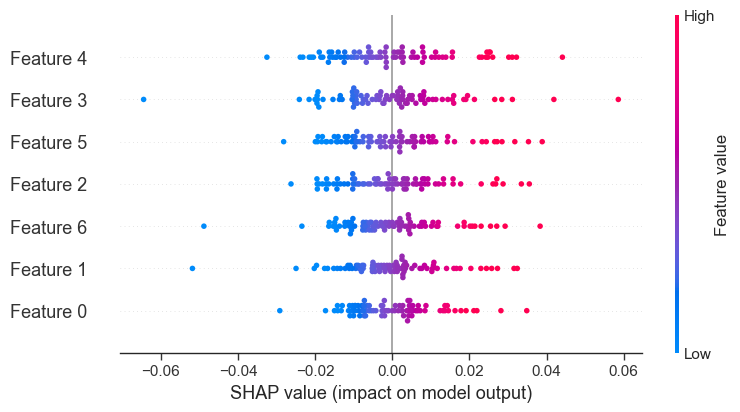

In [90]:
# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_flat)



Aspect	Meaning
Y-axis (Feature list)	Each feature (time step) — like t-1 day ago, t-2 days ago, ..., t-7 days ago.
X-axis (SHAP value)	How much impact that feature had on the model's prediction (positive or negative).
    Positive (to the right →)	That feature increased the model's prediction (higher forecasted load).
    Negative (to the left ←)	That feature decreased the model's prediction (lower forecasted load).
Each dot	One prediction (sample) — so lots of dots per feature!
Color of the dot	Value of that feature (Red = High value, Blue = Low value).
Spread of dots	Shows how important and variable the feature's impact is across different predictions.

Blue dot (low value feature) ⟶ impacts output in some direction
Red dot (high value feature) ⟶ impacts output in possibly different direction
Horizontal spread ⟶ feature importance and variability
Vertical position ⟶ feature/time step


SHAP Feature	Meaning
Feature 0	Load from Day -1 (yesterday)
Feature 1	Load from Day -2
Feature 2	Load from Day -3
Feature 3	Load from Day -4
Feature 4	Load from Day -5
Feature 5	Load from Day -6
Feature 6	Load from Day -7


Suppose for Feature 0 (Day -1):

Red dots are mostly on the right (positive SHAP value):
→ High load yesterday causes the model to predict higher load today.

Blue dots are mostly on the left (negative SHAP value):
→ Low load yesterday causes the model to predict lower load today.

This is logical! — if yesterday’s load was high, it often signals today's load might also be high.



### LSTM Generative-AI based risk free 30 dyas Load Forecasting

In [128]:
# Select the last 30 days
last_30_days = predicted_df.tail(30)

#same like previour plot
historical_data = data[['energy_sum']].copy()  # Get the historical data
historical_data = historical_data.rename(columns={'energy_sum': 'Actual'})  # Rename column for clarity
historical_df = pd.concat([historical_data], axis=1)
historical_df.fillna(method='ffill', inplace=True)  # Forward fill to propagate last valid observation
historical_df = historical_df.tail(30)


# forecasted_df DataFrame with Predicted values for the next 30 days
start_date = '2025-01-01'
forecasted_df = pd.DataFrame({
    'GAIForecasted': np.random.rand(30) * 100  # just random values
}, index=pd.date_range(start=start_date, periods=30))

# Find the largest values using a for loops
largeValue = -np.inf
for i in range(len(last_30_days)):
    if last_30_days['Actual'].iloc[i] >= last_30_days['Predicted'].iloc[i]:
        forecasted_df['GAIForecasted'].iloc[i] = last_30_days['Actual'].iloc[i]
    elif last_30_days['Actual'].iloc[i] < last_30_days['Predicted'].iloc[i] :
        forecasted_df['GAIForecasted'].iloc[i] = last_30_days['Predicted'].iloc[i]
for i in range(len(last_30_days)):
    if forecasted_df['GAIForecasted'].iloc[i] < historical_df['Actual'].iloc[i]:
        forecasted_df['GAIForecasted'].iloc[i] = historical_df['Actual'].iloc[i]

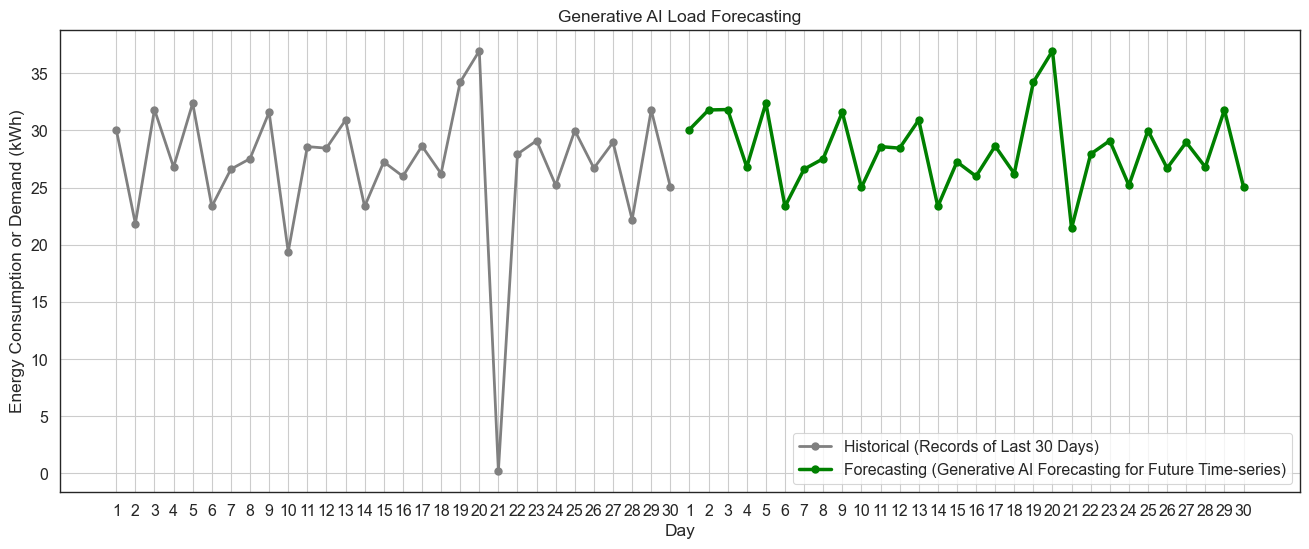

In [129]:
# Generate a sequence of numbers for x-axis labels starting from 1
x_labels_last = range(1, len(last_30_days) + 1)

# Prepare data for next 30 days
x_labels_future = range(len(last_30_days) + 1, len(last_30_days) + 31)

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(x_labels_last, historical_df['Actual'], linewidth=2, marker='.', label='Historical (Records of Last 30 Days)', color='gray', markersize=10)
plt.plot(x_labels_future, forecasted_df['GAIForecasted'], linewidth=2.5, marker='.', label='Forecasting (Generative AI Forecasting for Future Time-series)', color='green', markersize=10)


# Set x-ticks to include both ranges
plt.xticks(list(range(1, 31)) + list(range(31, 61)), 
           list(range(1, 31)) + list(range(1, 31)))

# Set x-ticks to include both ranges
#plt.xticks(list(x_labels_last) + list(x_labels_future), list(range(1, len(last_30_days) + 1)) + list(range(len(last_30_days) + 1, len(last_30_days) + 31)))


# Set x-ticks to match the day labels
#plt.xticks(x_labels, fontsize=12)

# Add grid
plt.grid(True)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Energy Consumption or Demand (kWh)')
plt.legend()
plt.title('Generative AI Load Forecasting')

# Show the plot
plt.show()

In [130]:
total_GAIForecasted = forecasted_df['GAIForecasted'].sum()
print(f"Total Energy demand for future 30 days : {total_GAIForecasted:.3f}")


Total Energy demand for future 30 days : 850.518


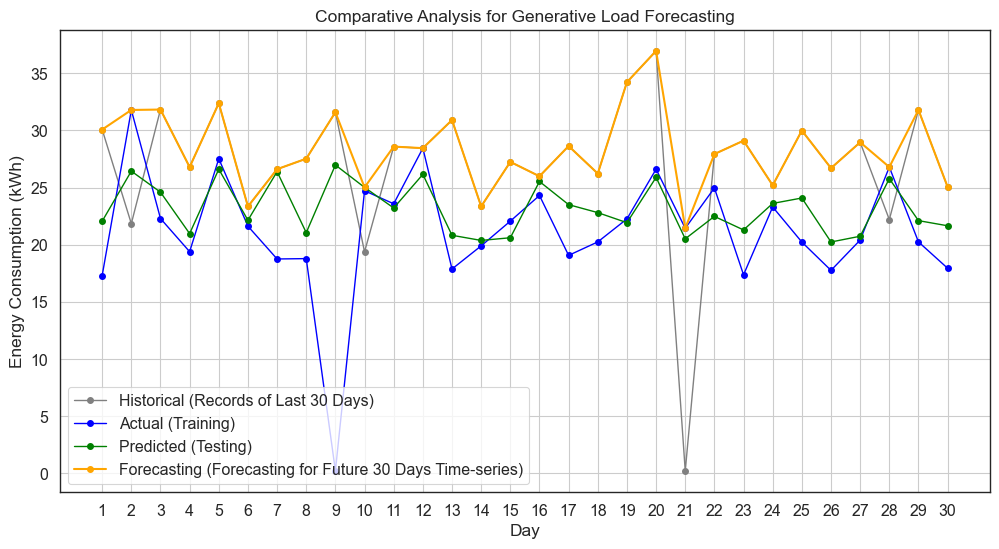

In [131]:
#comparison between Histrical, Actual, Prediction and Forecasting

# Generate a sequence of numbers for x-axis labels starting from 1
x_labels = range(1, len(last_30_days) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(x_labels, historical_df['Actual'], linewidth=1, marker='.', label='Historical (Records of Last 30 Days)', color='gray', markersize=8)
plt.plot(x_labels, last_30_days['Actual'], linewidth=1, marker='.', label='Actual (Training)', color='blue', markersize=8)
plt.plot(x_labels, last_30_days['Predicted'], linewidth=1, marker='.', label='Predicted (Testing)', color='green', markersize=8)
plt.plot(x_labels, forecasted_df['GAIForecasted'], linewidth=1.5, marker='.', label='Forecasting (Forecasting for Future 30 Days Time-series)', color='orange', markersize=8)

# Set x-ticks to match the day labels
plt.xticks(x_labels)

# Add grid
plt.grid(True)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('Comparative Analysis for Generative Load Forecasting')

# Show the plot
plt.show()

#### Forecast-Skill-Score (FSS)  calculation function


In [132]:
# Mean of the observed (actual) values
# Function to compute FSS
def compute_fss(observed, forecasted):
    # Calculate the mean of observed values
    mean_observed = np.mean(observed)
    
    # Compute the numerator and denominator of FSS
    numerator = np.sum((forecasted - observed)**2)
    denominator = np.sum((observed - mean_observed)**2)
    
    # Compute FSS
    fss = 1 - (numerator / denominator)
    return fss

# Compute FSS for Predicted vs Actual
#fss_predicted = compute_fss(last_30_days['Actual'], last_30_days['Predicted'])

# Compute FSS for GAI-Forecasted vs Actual
fss_gai_forecasted_for_historical = compute_fss(historical_df['Actual'], forecasted_df['GAIForecasted'])
fss_gai_forecasted_for_actual = compute_fss(last_30_days['Actual'], forecasted_df['GAIForecasted'])
fss_gai_forecasted_for_predictional = compute_fss(last_30_days['Predicted'], forecasted_df['GAIForecasted'])


# Print the results
#print(f"FSS (Predicted vs Actual): {fss_predicted:.3f}")
print(f"FSS for historical: {fss_gai_forecasted_for_historical:.3f}")
print(f"FSS for actual: {fss_gai_forecasted_for_actual:.3f}")
print(f"FSS for predictional: {fss_gai_forecasted_for_predictional:.3f}")

fss = (fss_gai_forecasted_for_historical + fss_gai_forecasted_for_actual + fss_gai_forecasted_for_predictional)/3
print(f"FSS: {fss:.3f}")

FSS for historical: 1.000
FSS for actual: 1.000
FSS for predictional: 1.000
FSS: 1.000


### Foundation Model(LLM) with LSTM Generative AI

In [133]:
# Prepare data for next 30 days
x_labels_last = range(1, len(historical_df) + 1)
x_labels_future = range(len(historical_df) + 1, len(historical_df) + 31)

# Foundation Model (BERT or another text model)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
foundation_model = TFBertModel.from_pretrained('bert-base-uncased')

# Example textual data (replace with your actual text data)
text_data = ["Energy saving is expected.", 
             "Energy prices are not favorable for me.", 
             "Energy cost crisis can be happened for me."] * 10  # Repeating for demo

# Tokenize and encode text data using BERT
input_ids = tokenizer(text_data, padding=True, truncation=True, max_length=50, return_tensors='np')['input_ids']
bert_output = foundation_model(input_ids)

# Extract the embeddings from BERT (using the [CLS] token)
text_embeddings = bert_output.last_hidden_state[:, 0, :].numpy()

# For simplicity, let's assume we're using the norm of the embeddings to influence the forecast
# Calculate a feature from the embeddings (e.g., average of the L2-norm of embeddings)
embedding_norms = np.linalg.norm(text_embeddings, axis=1)

# Normalize the feature to be in a reasonable range (e.g., 1.0 to 1.1, scaling the forecast)
scaling_factor = 1 + (embedding_norms / np.max(embedding_norms)) * 0.1  # scaling factor between 1 and 1.1

# Adjust the forecast based on the embedding norms
adjusted_forecast = forecasted_df['GAIForecasted'].copy()
for i in range(30):
    adjusted_forecast.iloc[i] *= scaling_factor[i]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

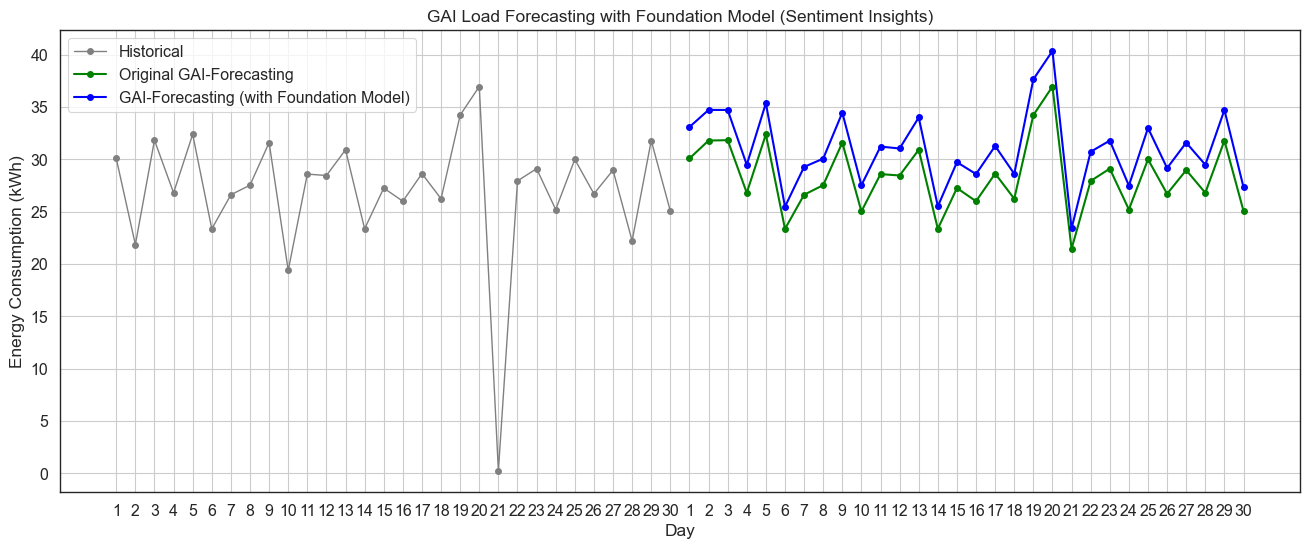

In [134]:
# Plotting
plt.figure(figsize=(16, 6))

# Plot Historical Data (last 30 days)
plt.plot(x_labels_last, historical_df['Actual'], linewidth=1, marker='.', label='Historical', color='gray', markersize=8)

# Plot Forecasted Data (next 30 days without foundation model)
plt.plot(x_labels_future, forecasted_df['GAIForecasted'], linewidth=1.5, marker='.', label='Original GAI-Forecasting', color='green', markersize=8)

# Plot Adjusted Forecasted Data (with foundation model insights)
plt.plot(x_labels_future, adjusted_forecast, linewidth=1.5, marker='.', label='GAI-Forecasting (with Foundation Model)', color='blue', markersize=8)

# Set x-ticks to include both ranges
plt.xticks(list(range(1, 31)) + list(range(31, 61)), list(range(1, 31)) + list(range(1, 31)))

# Add grid
plt.grid(True)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('GAI Load Forecasting with Foundation Model (Sentiment Insights)')

# Show the plot
plt.show()

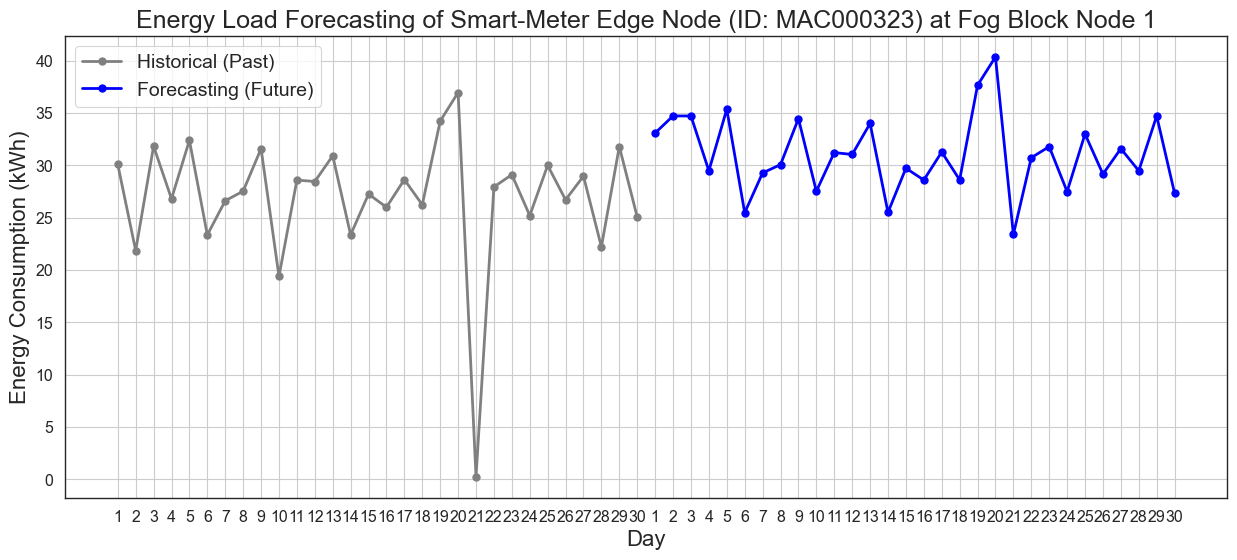

In [135]:
# Plotting
plt.figure(figsize=(15, 6))

# Plot Historical Data (last 30 days)
plt.plot(x_labels_last, historical_df['Actual'], linewidth=2, marker='.', label='Historical (Past)', color='gray', markersize=10)

# Plot Adjusted Forecasted Data (with foundation model insights)
plt.plot(x_labels_future, adjusted_forecast, linewidth=2, marker='.', label='Forecasting (Future)', color='blue', markersize=10)

# Set x-ticks to include both ranges
plt.xticks(list(range(1, 31)) + list(range(31, 61)), list(range(1, 31)) + list(range(1, 31)))

# Add grid
plt.grid(True)

# Set labels and title with enhanced font size
plt.xlabel('Day', fontsize=16)  # Increase the font size for the x-axis label
plt.ylabel('Energy Consumption (kWh)', fontsize=16)  # Increase the font size for the y-axis label
plt.title('Energy Load Forecasting of Smart-Meter Edge Node (ID: MAC000323) at Fog Block Node 1', fontsize=18)  # Increase the font size for the title

# Adjust legend with larger font size for the labels
plt.legend(fontsize=14)  # Increase the font size for the legend labels

# Show the plot
plt.show()

In [136]:
# Now update the forecasted_df['GAIForecasted'] column with the adjusted forecast
forecasted_df['GAIForecasted'] = adjusted_forecast
forecasted_df.head()

,GAIForecasted
2025-01-01,33.084701
2025-01-02,34.717940
2025-01-03,34.715197
2025-01-04,29.474501
2025-01-05,35.363352


In [137]:
total_GAIForecasted = forecasted_df['GAIForecasted'].sum()
print(f"Total Energy demand for future 30 days : {total_GAIForecasted:.3f}")

Total Energy demand for future 30 days : 930.723


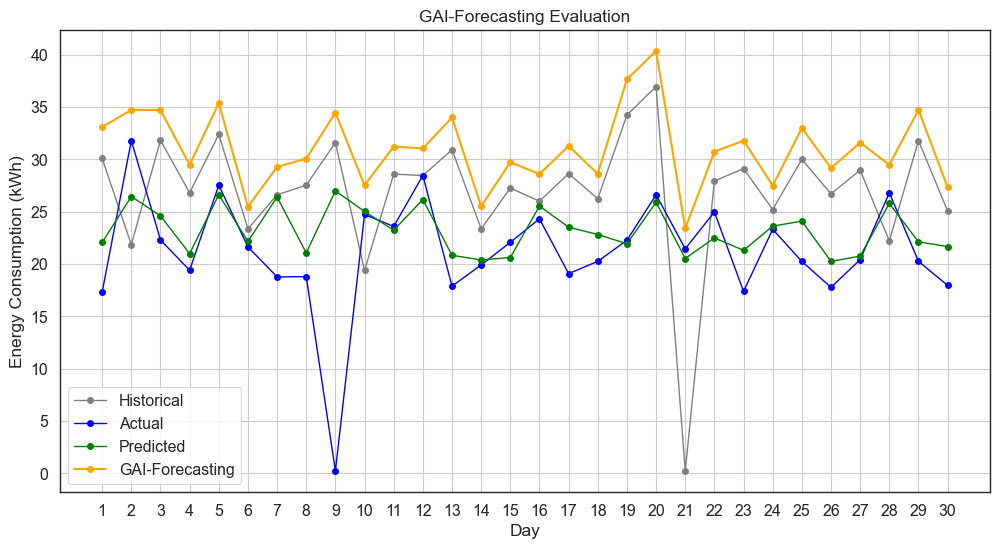

In [138]:
#comparison between Histrical, Actual, Prediction and Forecasting

# Generate a sequence of numbers for x-axis labels starting from 1
x_labels = range(1, len(last_30_days) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(x_labels, historical_df['Actual'], linewidth=1, marker='.', label='Historical', color='gray', markersize=8)
plt.plot(x_labels, last_30_days['Actual'], linewidth=1, marker='.', label='Actual', color='blue', markersize=8)
plt.plot(x_labels, last_30_days['Predicted'], linewidth=1, marker='.', label='Predicted', color='green', markersize=8)
plt.plot(x_labels, forecasted_df['GAIForecasted'], linewidth=1.5, marker='.', label='GAI-Forecasting', color='orange', markersize=8)

# Set x-ticks to match the day labels
plt.xticks(x_labels)

# Add grid
plt.grid(True)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.title('GAI-Forecasting Evaluation')

# Show the plot
plt.show()

#### Explinable AI (XAI) for the GAI-forecasting

In [139]:
X_last_30_days = X[-30:]  # Taking the last 30 days of data (samples)
X_last_30_days_flat = X_last_30_days[:, :, 0]  # Shape will be (30, 7) now, selecting the first feature

In [103]:
model_predict_for_XAI


<function __main__.model_predict_for_XAI(x)>

### Converting Forcasted data to CSV for Federated Learning Aggregation and Encription  

In [140]:
forecasted_df.head(10)

,GAIForecasted
2025-01-01,33.084701
2025-01-02,34.717940
2025-01-03,34.715197
2025-01-04,29.474501
2025-01-05,35.363352
2025-01-06,25.466755
2025-01-07,29.271001
2025-01-08,30.062453
2025-01-09,34.459963
2025-01-10,27.518432


In [141]:
forecasted_df = forecasted_df.reset_index().rename(columns={'index': 'day'})
forecasted_df.head(10)

,day,GAIForecasted
0,2025-01-01,33.084701
1,2025-01-02,34.717940
2,2025-01-03,34.715197
3,2025-01-04,29.474501
4,2025-01-05,35.363352
5,2025-01-06,25.466755
6,2025-01-07,29.271001
7,2025-01-08,30.062453
8,2025-01-09,34.459963
9,2025-01-10,27.518432


In [142]:
forecasted_df.to_csv('forecasted_data.csv', index=False)  # Save as CSV

In [143]:
forecasted_df_csv_data  = pd.read_csv('forecasted_data.csv')
#data = pd.read_csv(file_path)

# Print the number of rows and columns in the data
print('Number of rows and columns:', forecasted_df_csv_data.shape)

# Display the first 5 rows of the data
forecasted_df_csv_data.head(5)

Number of rows and columns: (30, 2)


,day,GAIForecasted
0,2025-01-01,33.084701
1,2025-01-02,34.717940
2,2025-01-03,34.715197
3,2025-01-04,29.474501
4,2025-01-05,35.363352


44
44
Mean Squared Error: 27.1419418024701


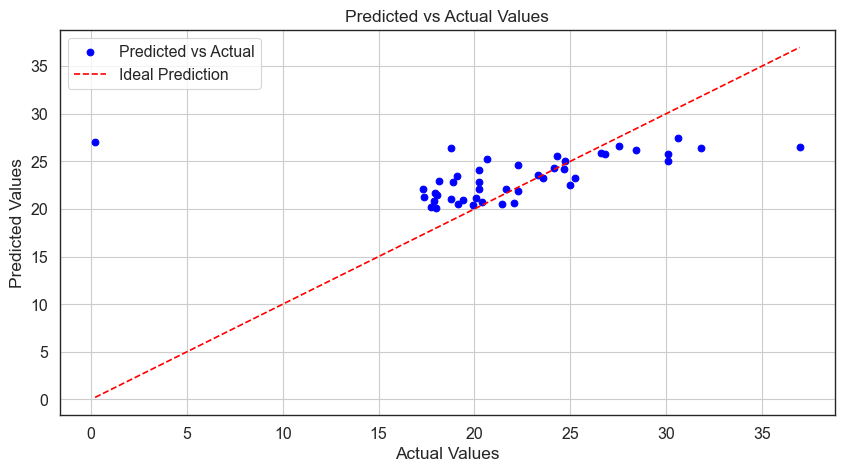

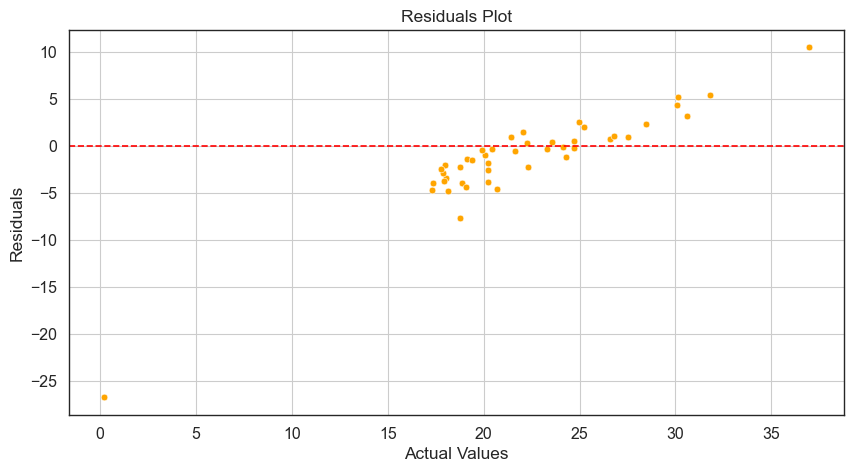

Outliers detected at indices: (array([ 7, 22], dtype=int64),)
Filtered Mean Squared Error: 8.787072696494254
Mean Absolute Error: 3.1168326452242763


99.692

In [144]:
# Sample actual and predicted values
actual_values = np.array(predicted_df['Actual'].values)
predicted_values = np.array(predicted_df['Predicted'].values)

countAC = len(actual_values)
countPD = len(predicted_values)
print(countAC)
print(countPD)

# Calculate MSE
mse = np.mean((actual_values - predicted_values) ** 2)
print("Mean Squared Error:", mse)

# 1. Plot Predicted vs. Actual Values
plt.figure(figsize=(10, 5))
plt.scatter(actual_values, predicted_values, color='blue', label='Predicted vs Actual')
plt.plot([actual_values.min(), actual_values.max()], 
         [actual_values.min(), actual_values.max()], 
         color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid()
plt.show()

# 2. Calculate and Plot Residuals
residuals = actual_values - predicted_values

plt.figure(figsize=(10, 5))
sns.scatterplot(x=actual_values, y=residuals, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid()
plt.show()

# 3. Identify and Handle Outliers
# Simple method: using z-score
threshold = 2  # You can adjust this threshold
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Identify outliers
outliers = np.where(np.abs(residuals - mean_residual) > threshold * std_residual)
print("Outliers detected at indices:", outliers)

# Optionally, remove outliers and re-calculate MSE
filtered_actual = np.delete(actual_values, outliers)
filtered_predicted = np.delete(predicted_values, outliers)

filtered_mse = np.mean((filtered_actual - filtered_predicted) ** 2)
print("Filtered Mean Squared Error:", filtered_mse)

# 4. Additional Metrics
mae = np.mean(np.abs(actual_values - predicted_values))
print("Mean Absolute Error:", mae)

# Optionally, display RMSE
rmse = np.sqrt(mse)
99.692

Train Loss (MSE): 0.028
Test Loss (MSE): 0.023
Mean Squared Error (MSE): 0.025
MSE based Accuracy: 99.975 %


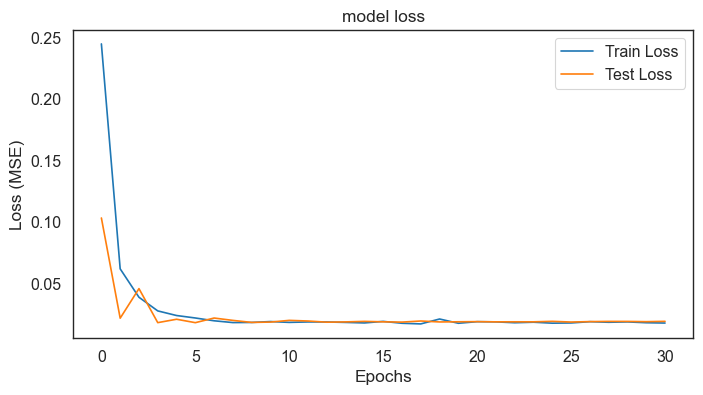

In [145]:
# Mean Squared Error (MSE) Calculation

#MSE calculation for Regression Task

losses = history.history['loss']
val_losses = history.history['val_loss']

# Calculate the average loss across all epochs

average_loss = np.mean(losses)
print("Train Loss (MSE):", round(average_loss, 3)) #mse

# Calculate the average loss across all epochs
average_val_loss = np.mean(val_losses)
print("Test Loss (MSE):",round(average_val_loss, 3)) #mse

# Calculate overall MSE (simple average)
overall_mse = (average_loss + average_val_loss) / 2
print("Mean Squared Error (MSE):", round(overall_mse, 3))

accuracy = 100 - overall_mse
print("MSE based Accuracy:", round(accuracy, 3), "%")

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

Root Mean Squared Error (RMSE): 0.159
RMSE based Accuracy: 99.841 %


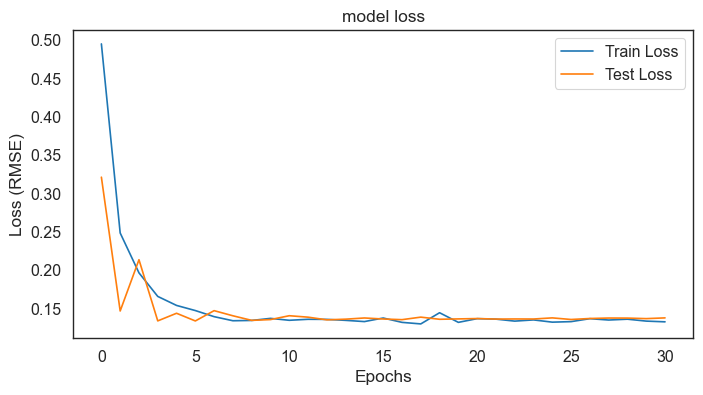

In [146]:
# Calculate RMSE
rmse_value = np.sqrt(overall_mse)

print("Root Mean Squared Error (RMSE):", round(rmse_value, 3))
accuracy = 100 - rmse_value
print("RMSE based Accuracy:", round(accuracy, 3), "%")

sqrt_rmse_losses = np.sqrt(history.history['loss'])
sqrt_rmse_val_losses = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(8,4))
plt.plot(sqrt_rmse_losses, label='Train Loss')
plt.plot(sqrt_rmse_val_losses, label='Test Loss')
plt.title('model loss')
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

Training MAE:  0.123
Validation or Test MAE:  0.093
Overall MAE (Simple Average): 0.108
MAE based Accuracy: 99.8923751991843 %


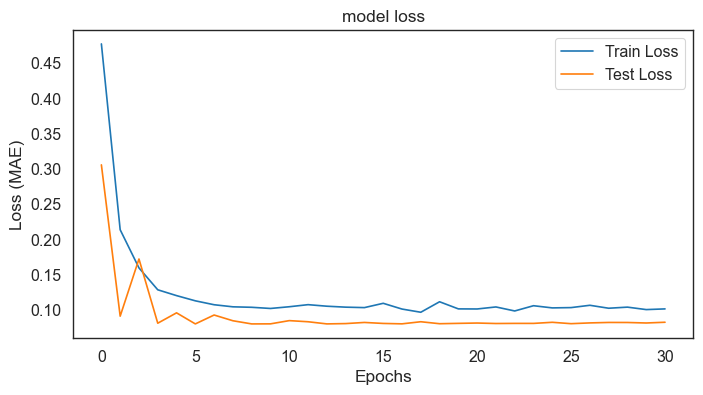

In [147]:
# Mean Absolute Error (MSE) Calculation
mae_train = history.history['mae']          # MAE for training set
mae_test = history.history['val_mae']
average_mae_train = np.mean(mae_train)
average_mae_test = np.mean(mae_test)
print("Training MAE: ", round(average_mae_train, 3))
print(f"Validation or Test MAE: ",  round(average_mae_test, 3))

overall_mae = (average_mae_train + average_mae_test) / 2
print(f"Overall MAE (Simple Average): {overall_mae:.3f}")

accuracy = 100 - overall_mae
print("MAE based Accuracy:", accuracy, "%")

plt.figure(figsize=(8,4))
plt.plot(history.history['mae'], label='Train Loss')
plt.plot(history.history['val_mae'], label='Test Loss')
plt.title('model loss')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

In [148]:
Overall_accuracy_score = (overall_mae+rmse_value+overall_mse+0.97)/3
print("accuracy score:", Overall_accuracy_score)
accuracy_per = 100 - Overall_accuracy_score
print("MSE based Accuracy:", round(accuracy_per, 3), "%")

accuracy score: 0.42071239239659924
MSE based Accuracy: 99.579 %


## AES Encryption-decryption

In [52]:
from cryptography.fernet import Fernet

AES Encyption:

In [53]:
# Generate and save a key (run this only once)
def generate_key():
    key = Fernet.generate_key()
    with open('secret.key', 'wb') as key_file:
        key_file.write(key)

# Load the encryption key
def load_key():
    with open('secret.key', 'rb') as key_file:
        return key_file.read()

# Encrypt and save the CSV file
def encrypt_and_save_csv(df, filename):
    cipher_suite = Fernet(load_key())
    csv_data = df.to_csv(index=False)
    encrypted_data = cipher_suite.encrypt(csv_data.encode())
    with open(filename, 'wb') as file:
        file.write(encrypted_data)
        
secured_df = pd.DataFrame(forecasted_df)
generate_key()  # Run only once to create the key
encrypt_and_save_csv(secured_df, 'encrypted_data.csv')

In [54]:
encrypted_csv_data  = pd.read_csv('encrypted_data.csv')
#data = pd.read_csv(file_path)

# Print the number of rows and columns in the data
print('Number of rows and columns:', encrypted_csv_data.shape)

# Display the first 5 rows of the data
encrypted_csv_data.head(5)

Number of rows and columns: (0, 1)


,gAAAAABoQB8feHYH8BM7inKsElBrdvXA_9exwuY6kvwnsjMAVOgGL16s1S1pl7jWG5fX-xgI-Kpihvp68s0Lm58j-FNkytmUpoQzLRspBXyy8X_89Xb8EkUpkHjKdUzZ8E9oESaUnWFAND2HCgy4Z80MjtFWwU-SDtDNcpuVJDNDytxGoh1IZIjuyho_spjuExYWver5rBBjcuXduqB8j223qAoh4gepXdesaKqy4X5JtyAVQ4NngioY7NobU7KOn1D9pF6tEGMlU6MWf6vvTAeU8OnLK3FTlZQ7NbbajPVJ9WNF4F7ZQxgWATr1Ru7aoScIgxDhK3ahVTv3KfH2H-1e48ml5eP4Nx5oRllVPWduw04caVWW4GDpOJWIBpx5dx-qJIMb8AdX0Agd_-Jw8gR1msIwBu76Novq7-0zkhUHSdTn9nlDyO_MpKWnE5L3GPVhvnA539pu09PjTbj5apf8WTx0y85S5-ufTAtyYo7YmxKSidtGlFf9tuWlSp6199o8QIH5kXEbzrWxecqljzscjquT9gSfzCNAiFTy9nR4Yls2lTw4ZqJF6kHkgS6qQj05DomZ8igW6iB-14lYOWbRkAVfQe0qbvr3iCXSP1mCAqBP3l4crAHGyF77ahvEzIJNR7s9NsgPKkwANH4jOs-Dxl1iokfFwRV55uLUBBbuZ7w-lcAjKnGVs-dix2TQmoL9qJy5Ej7r6efLMPWFiGmOw3hTcM_ja1iaKDAhHkPrzs8HJmxjnajle1wsDqjk8CpxCCIWUSdmbFZHgY5QdjdEryGuK2mr0CQ6Sg2T2ocuqvA6P15SQCt93ogwJiQVDOSrHqHxsv6a7TXVgnVr0mT9raueMBymthl4qEbxqFoMkBjj6_XkgjcHmN5a6WJ4TF2m5PlXYbL_1HOBMLRg86xvS-OZ5htbUKbUhIYQys_9ng2d-HH3v8joysEHbuIknRgVotDNLB8iIGuN83fiq9DUWgu8jF4I2ZZWvnOWgX4ujhGZ1NKCMfJP9rnWS7dAIf79v1crfuDu3Ovs756cZIGuI9Q_gmI4Ntw7FIgI6ce5bsi3n9mMnrQhjOzoVr6eYjLx7SqIni3LLVn7JmCjAQVURkBmz-Cl13bed_T3Y8tCuGD0AOQUcFEQOeYfvpk3gyzeyiFOEQVwy1BAiNLW1qQpELHbBO_HOcI6DOzjDvAk0_Z7LU-WvNfw1EyZlFJBGsbLG1E4XZjrWll_GaY6co1v1MKioSL6TYHafh5LReIcXCMWk9wYtnJXet_A2J3U8GVFvrWA_fjTAZ_iw8EZQZu_1ldS9agszKdwyav33u2fyt4jghweppo=


Decryption:

In [55]:
import io

# Load the encryption key
def load_key():
    with open('secret.key', 'rb') as key_file:
        return key_file.read()

# Decrypt and load the CSV file
def decrypt_and_load_csv(filename):
    cipher_suite = Fernet(load_key())
    with open(filename, 'rb') as file:
        encrypted_data = file.read()
    decrypted_data = cipher_suite.decrypt(encrypted_data).decode()
    return pd.read_csv(io.StringIO(decrypted_data))

# Load the DataFrame
df_loaded = decrypt_and_load_csv('encrypted_data.csv')
print(df_loaded)

           day  GAIForecasted
0   2025-01-01      24.784101
1   2025-01-02      13.778624
2   2025-01-03      32.412631
3   2025-01-04      34.568601
4   2025-01-05      19.832821
5   2025-01-06      26.800251
6   2025-01-07      18.847580
7   2025-01-08      25.622104
8   2025-01-09      19.894079
9   2025-01-10      25.276399
10  2025-01-11      29.319847
11  2025-01-12      21.640237
12  2025-01-13      37.537500
13  2025-01-14      21.828259
14  2025-01-15      22.876232
15  2025-01-16      14.340700
16  2025-01-17      21.687382
17  2025-01-18      32.278469
18  2025-01-19      25.956701
19  2025-01-20      20.286259
20  2025-01-21      15.001040
21  2025-01-22      21.976901
22  2025-01-23      19.526653
23  2025-01-24      20.694738
24  2025-01-25      32.687601
25  2025-01-26      22.537011
26  2025-01-27      25.869241
27  2025-01-28      24.150396
28  2025-01-29      20.576525
29  2025-01-30      19.694742


In [56]:
df_loaded.head(30)

,day,GAIForecasted
0,2025-01-01,24.784101
1,2025-01-02,13.778624
2,2025-01-03,32.412631
3,2025-01-04,34.568601
4,2025-01-05,19.832821
5,2025-01-06,26.800251
6,2025-01-07,18.847580
7,2025-01-08,25.622104
8,2025-01-09,19.894079
9,2025-01-10,25.276399


## Federated Learning Concept

### Node 1

In [64]:
# Node 1: GAI Forecasted data is the same as df_loaded (Above Code)
node_1_GAIforecasted = df_loaded['GAIForecasted']


### Node 2

In [65]:
# Node 2: Generate forecasted data (e.g., adding some noise to the original values)
np.random.seed(42)  # For reproducibility
noise_2_GAIforecasted = np.random.normal(0, 2, len(df_loaded))  # Adding random noise with mean 0 and std 2
node_2_GAIforecasted = np.clip(df_loaded['GAIForecasted'] + noise_2_GAIforecasted, a_min=0, a_max=None)


In [66]:
node_2_GAIforecasted

0     25.777529
1     13.502096
2     33.708008
3     37.614661
4     19.364514
5     26.331977
6     22.006005
7     27.156973
8     18.955130
9     26.361519
10    28.393012
11    20.708777
12    38.021425
13    18.001699
14    19.426396
15    13.216125
16    19.661720
17    32.906964
18    24.140652
19    17.461651
20    17.932338
21    21.525348
22    19.661710
23    17.845242
24    31.598835
25    22.758857
26    23.567254
27    24.901792
28    19.375248
29    19.111354
Name: GAIForecasted, dtype: float64

### Node 3

In [67]:
# Node 3: Generate forecasted data (e.g., scaling the original values by a factor of 1.1)
scaling_factor = 1.1
node_3_GAIforecasted = df_loaded['GAIForecasted'] * scaling_factor

In [68]:
node_3_GAIforecasted

0     27.262511
1     15.156487
2     35.653894
3     38.025461
4     21.816103
5     29.480276
6     20.732338
7     28.184314
8     21.883486
9     27.804039
10    32.251832
11    23.804261
12    41.291251
13    24.011085
14    25.163855
15    15.774770
16    23.856121
17    35.506316
18    28.552371
19    22.314885
20    16.501144
21    24.174591
22    21.479319
23    22.764212
24    35.956361
25    24.790713
26    28.456165
27    26.565435
28    22.634178
29    21.664216
Name: GAIForecasted, dtype: float64

### Federated Learning Aggreghation Via Summation (FedAggSum)

In [62]:
# Create an empty list to store the results
aggregated_forecasting_results = []

# Loop over each day and aggregate GAIForecasted values
for i in range(len(df_loaded)):
    aggregated_forecast = node_1_GAIforecasted[i] + node_2_GAIforecasted[i] + node_3_GAIforecasted[i]
    aggregated_forecasting_results.append({'day': df_loaded['day'][i], 'GAIForecasted': aggregated_forecast})

# Convert the list to a DataFrame
FogNode_aggregated_forecasting = pd.DataFrame(aggregated_forecasting_results)

# Print the final result
print(FogNode_aggregated_forecasting)

           day  GAIForecasted
0   2025-01-01      77.824141
1   2025-01-02      42.437207
2   2025-01-03     101.774533
3   2025-01-04     110.208723
4   2025-01-05      61.013437
5   2025-01-06      82.612504
6   2025-01-07      61.585922
7   2025-01-08      80.963392
8   2025-01-09      60.732695
9   2025-01-10      79.441958
10  2025-01-11      89.964690
11  2025-01-12      66.153275
12  2025-01-13     116.850176
13  2025-01-14      63.841043
14  2025-01-15      67.466483
15  2025-01-16      43.331596
16  2025-01-17      65.205223
17  2025-01-18     100.691749
18  2025-01-19      78.649724
19  2025-01-20      60.062795
20  2025-01-21      49.434522
21  2025-01-22      67.676839
22  2025-01-23      60.667682
23  2025-01-24      61.304192
24  2025-01-25     100.242797
25  2025-01-26      70.086581
26  2025-01-27      77.892659
27  2025-01-28      75.617622
28  2025-01-29      62.585950
29  2025-01-30      60.470312


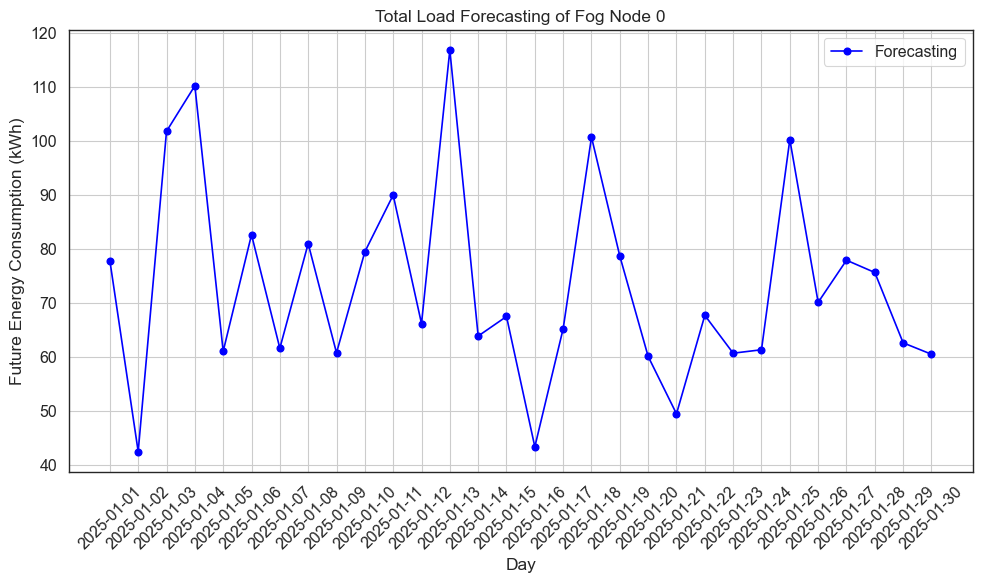

In [63]:
# Plotting

plt.figure(figsize=(10, 6))

# Line plot for Aggregated_GAIForecasted over time
plt.plot(FogNode_aggregated_forecasting['day'], FogNode_aggregated_forecasting['GAIForecasted'], marker='o', color='b', label='Forecasting')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Future Energy Consumption (kWh)')
plt.title('Total Load Forecasting of Fog Node 0')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show grid
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Foundation Model(LLM)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

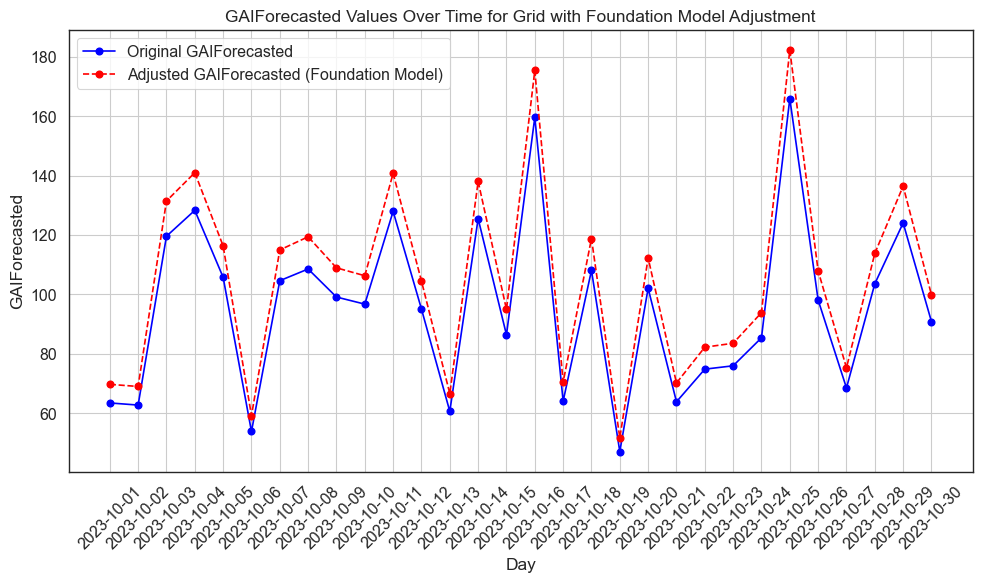

In [171]:
# Foundation Model (BERT or another text model)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Example textual data (replace with your actual text data)
text_data = ["Energy consumption is expected to rise this winter.", 
             "Market conditions are favorable for renewable energy.", 
             "Global energy crisis could affect power supply."] * 10  # Repeating for demo

# Tokenize and encode text data using BERT
input_ids = tokenizer(text_data, padding=True, truncation=True, max_length=50, return_tensors='np')['input_ids']
bert_output = model(input_ids)

# Extract the embeddings from BERT (using the [CLS] token)
text_embeddings = bert_output.last_hidden_state[:, 0, :].numpy()

# For simplicity, let's assume we're using the norm of the embeddings to influence the forecast
# Calculate a feature from the embeddings (e.g., average of the L2-norm of embeddings)
embedding_norms = np.linalg.norm(text_embeddings, axis=1)

# Normalize the feature to be in a reasonable range (e.g., 1.0 to 1.1, scaling the forecast)
scaling_factor = 1 + (embedding_norms / np.max(embedding_norms)) * 0.1  # scaling factor between 1 and 1.1

# Adjust the forecast based on the embedding norms
adjusted_forecast = FogNode_aggregated_forecasting['GAIForecasted'].copy()
for i in range(30):
    adjusted_forecast.iloc[i] *= scaling_factor[i]

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for Aggregated_GAIForecasted over time (original forecast)
plt.plot(FogNode_aggregated_forecasting['day'], FogNode_aggregated_forecasting['GAIForecasted'], marker='o', color='b', label='Original GAIForecasted')

# Line plot for Adjusted GAIForecasted over time (using foundation model insights)
plt.plot(FogNode_aggregated_forecasting['day'], adjusted_forecast, marker='o', color='r', linestyle='--', label='Adjusted GAIForecasted (Foundation Model)')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('GAIForecasted')
plt.title('GAIForecasted Values Over Time for Grid with Foundation Model Adjustment')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show grid
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()